## Using this Notebook

We use the RCMAP fractional shrub cover dataset (2000–2020) to quantify shrub cover inside the Witch Fire area over time.

We are following the same process as the previous notebook. Refer back to the cedar notebook if you need clarifications on the step process. 

### Step 0: Load stored variables
- From previous notebooks call stored variables.
### Step 1: Libraries
- Import required libraries.
### Step 2: Open and inspect the RCMAP data and build the shrub raster
- Build the shrub dataframes for Witch. Since we already downloaded the zip we can skip that step in this notebook
### Step 3: For each Witch Fire phase (pre- & post-) calculate summary statistics
- Load the shrub raster for that year from the zip.
- Reproject and clip it to the Cedar Fire boundary.
- Calculate summary shrub statistics (e.g., mean shrub cover).
### Step 4: Create a timeseries dataframe
- Combine pieces from previous step to prepare the dataframe for visualization
### Step 5: Save figures and csv summaries
- Save the shrub maps we made
- As we are now processing raw data, there is a new directory under data called 'processed' where csv are stored
### Step 6: Store key variables for use in later land cover and RCMAP notebooks.

### Step 0: Load stored variables

In [1]:
%store -r

### Step 1.1: Pull in our previous Cedar Fire data

In [ ]:
# ===========================================================
# Load Cedar Fire landcover variables (for comparison with Witch)
# ===========================================================

import numpy as np
import pandas as pd
from pathlib import Path

# Base directories (match your project setup)
PROJECT_ROOT = Path("C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery")
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "landcover"

# -----------------------------
# 1. Load Cedar shrub time series
# -----------------------------
cedar_time_csv = DATA_DIR / "cedar_shrub_cover_time.csv"
cedar_shrub_df = pd.read_csv(cedar_time_csv, index_col=0)

# -----------------------------
# 2. Load east–west summary table
# -----------------------------
cedar_summary_csv = DATA_DIR / "cedar_shrub_change_east_west_summary.csv"
cedar_summary_df = pd.read_csv(cedar_summary_csv)

# Extract Cohen's d
cohens_d = cedar_summary_df.loc[0, "cohens_d_east_minus_west"]

# -----------------------------
# 3. Load core numerical arrays saved earlier (NPZ)
# -----------------------------
npz_path = DATA_DIR / "cedar_core_arrays.npz"
cedar_npz = np.load(npz_path)

shrub_diff = cedar_npz["shrub_diff"]
east_values = cedar_npz["east_values"]
west_values = cedar_npz["west_values"]
east_mask = cedar_npz["east_mask"]
west_mask = cedar_npz["west_mask"]
transform_2000 = tuple(cedar_npz["transform_2000"])
transform_2020 = tuple(cedar_npz["transform_2020"])
cedar_bounds = cedar_npz["cedar_bounds"]

# -----------------------------
# 4. Print confirmation
# -----------------------------
print("Loaded Cedar Fire data successfully:")
print(f" - Time series shape: {cedar_shrub_df.shape}")
print(f" - Shrub change array shape: {shrub_diff.shape}")
print(f" - East values: {east_values.size} pixels")
print(f" - West values: {west_values.size} pixels")
print(f" - Cohen's d (east - west): {cohens_d:.3f}")
print(f" - Cedar bounds: {cedar_bounds}")


Loaded Cedar Fire data successfully:
 - Time series shape: (9, 8)
 - Shrub change array shape: (1115, 2226)
 - East values: 758151 pixels
 - West values: 380051 pixels
 - Cohen's d (east - west): 0.802
 - Cedar bounds: [ 265067.52952313 -576209.95418631  332496.66750624 -536096.26668806]


### Step 1.2: Libraries

In [3]:
# ===========================================================
# Witch Fire setup: libraries, directories, CRS
# ===========================================================

import geopandas as gpd
import rasterio
from rasterio import mask
import numpy as np
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# Project root & data dirs (same as Cedar)
PROJECT_ROOT = Path("C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery")
DATA_DIR = PROJECT_ROOT / "data"
BOUNDARY_DIR = DATA_DIR / "boundaries"
RAW_LANDCOVER_DIR = DATA_DIR / "raw" / "landcover"

# RCMAP shrub directory (already filled from Cedar notebook work)
RCMAP_SHRUB_DIR = RAW_LANDCOVER_DIR / "rcmap_shrub"

# Target CRS (same as Cedar)
target_crs = "EPSG:3310"

target_crs, RCMAP_SHRUB_DIR


('EPSG:3310',
 WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/data/raw/landcover/rcmap_shrub'))

### Step 2: Open and inspect the RCMAP data and build the shrub raster for Witch

In [4]:
# ===========================================================
# Map each year to its RCMAP shrub raster(s)
# ===========================================================

def find_rcmap_year_rasters(rcmap_shrub_dir):
    """
    Walk through the extracted shrub folders and group rasters by year.
    Returns a dict: {year (int): [list of Path objects]}.
    """
    rcmap_shrub_dir = Path(rcmap_shrub_dir)
    year_pattern = re.compile(r"(19|20)\d{2}")

    year_files = {}

    for tif_path in rcmap_shrub_dir.rglob("*.tif"):
        match = year_pattern.search(tif_path.name)
        if not match:
            # skip files without a year in the name
            continue

        year = int(match.group(0))
        year_files.setdefault(year, []).append(tif_path)

    return year_files

RCMAP_YEAR_FILES = find_rcmap_year_rasters(RCMAP_SHRUB_DIR)

print("Years found in RCMAP shrub bundles:")
for yr in sorted(RCMAP_YEAR_FILES.keys()):
    print(f"  {yr}: {len(RCMAP_YEAR_FILES[yr])} file(s)")


Years found in RCMAP shrub bundles:
  1998: 1 file(s)
  1999: 1 file(s)
  2000: 1 file(s)
  2001: 1 file(s)
  2002: 1 file(s)
  2003: 1 file(s)
  2004: 1 file(s)
  2005: 1 file(s)
  2006: 1 file(s)
  2007: 1 file(s)
  2008: 1 file(s)
  2009: 1 file(s)
  2010: 1 file(s)
  2011: 1 file(s)
  2012: 1 file(s)
  2013: 1 file(s)
  2014: 1 file(s)
  2015: 1 file(s)
  2016: 1 file(s)
  2017: 1 file(s)
  2018: 1 file(s)
  2019: 1 file(s)
  2020: 1 file(s)
  2021: 1 file(s)
  2022: 1 file(s)
  2023: 1 file(s)
  2024: 1 file(s)


In [5]:
# ===========================================================
# Witch Fire perimeter in EPSG:3310
# ===========================================================

try:
    fires_gdf
    print("Using existing fires_gdf.")
    fires_gdf = fires_gdf.to_crs(target_crs)
except NameError:
    print("Loading historic fire perimeters from disk.")
    fires_gdf = gpd.read_file(BOUNDARY_DIR / "California_Historic_Fire_Perimeter.shp").to_crs(target_crs)

print("Fire perimeter columns:", fires_gdf.columns)

# Filter to Witch Fire, 2007
witch_3310 = fires_gdf[
    fires_gdf["FIRE_NAME"].str.upper().str.contains("WITCH")
    & (fires_gdf["YEAR_"] == 2007)
].copy()

print("Witch CRS:", witch_3310.crs)
print("Witch bounds:", witch_3310.total_bounds)
witch_3310.head()


Using existing fires_gdf.
Fire perimeter columns: Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NA', 'IRWINID', 'FIRE_NUM',
       'COMPLEX_ID', 'DECADES', 'geometry'],
      dtype='object')
Witch CRS: EPSG:3310
Witch bounds: [ 261823.79417401 -564886.8358195   314369.7967777  -526451.06090121]


,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
6155,2007,CA,CDF,MVU,WITCH,00000082,2007-10-21,2007-10-31,9,7,1,162070.0,None,None,None,00000082,None,2000-2009,"POLYGON ((296364.073 -527593.394, 296370.072 -..."


In [6]:
# ===========================================================
# Helper: load + clip a RCMAP shrub raster for any fire AOI
# ===========================================================

def load_and_clip_rcmap_year(year, boundary_gdf):
    """
    Load the RCMAP shrub raster for a given year and clip it to the given boundary.

    Returns:
      - band (2D numpy array, shrub cover with NaNs where nodata or out-of-range)
      - transform (affine transform for the clipped raster)
      - meta (raster metadata dict, updated for the clip)
    """
    tif_list = RCMAP_YEAR_FILES.get(year)
    if not tif_list:
        raise ValueError(f"No RCMAP rasters found for year {year}")

    # We have exactly 1 file per year in this setup
    tif_path = tif_list[0]
    print(f"\n=== Loading RCMAP shrub for {year} ===")
    print(f"Using file: {tif_path}")

    with rasterio.open(tif_path) as src:
        print("RCMAP CRS:", src.crs)
        print("RCMAP bounds:", src.bounds)
        print("RCMAP nodata:", src.nodata)

        # Reproject boundary to raster CRS
        boundary_in_raster_crs = boundary_gdf.to_crs(src.crs)

        # Clip raster to boundary
        out_img, out_transform = mask.mask(
            src,
            boundary_in_raster_crs.geometry,
            crop=True
        )
        out_meta = src.meta.copy()

    data = out_img.astype("float32")
    nodata = out_meta.get("nodata", None)

    band = data[0]

    # Replace nodata with NaN
    if nodata is not None:
        band[band == nodata] = np.nan

    # Enforce valid shrub % range
    band[band < 0] = np.nan
    band[band > 100] = np.nan

    # Update meta
    out_meta.update({
        "height": band.shape[0],
        "width": band.shape[1],
        "transform": out_transform
    })

    print("Clipped array shape (rows, cols):", band.shape)
    if np.isnan(band).all():
        print("All values are NaN after clipping — no overlapping pixels?")
    else:
        print("Min shrub %:", np.nanmin(band))
        print("Max shrub %:", np.nanmax(band))

    return band, out_transform, out_meta

# Quick sanity test for Witch pre-fire year (e.g., 2000)
witch_shrub_2000, witch_shrub_2000_transform, witch_shrub_2000_meta = load_and_clip_rcmap_year(
    2000, witch_3310
)



=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 96.0


### Step 3: For each Witch Fire phase (pre- & post-) calculate summary statistics

In [7]:
# ===========================================================
# Witch Fire shrub time series across WITCH_YEARS
# ===========================================================

# Example (if not already defined). Comment this out if WITCH_YEARS already exists.
# WITCH_YEARS = {
#     "pre_fire": [2000, 2005],
#     "fire_year": [2007],
#     "post_fire": [2010, 2015, 2020]
# }

witch_year_list = (
    WITCH_YEARS["pre_fire"]
    + WITCH_YEARS["fire_year"]
    + WITCH_YEARS["post_fire"]
)

records = []

for year in witch_year_list:
    print(f"\n--- Processing Witch year {year} ---")
    band, _, _ = load_and_clip_rcmap_year(year, witch_3310)

    total_pixels = band.size
    valid_mask = ~np.isnan(band)
    pixel_count = int(valid_mask.sum())
    invalid_pixel_count = total_pixels - pixel_count

    if pixel_count == 0:
        mean_shrub = np.nan
        min_shrub = np.nan
        max_shrub = np.nan
        valid_fraction = 0.0
    else:
        mean_shrub = float(np.nanmean(band))
        min_shrub = float(np.nanmin(band))
        max_shrub = float(np.nanmax(band))
        valid_fraction = pixel_count / total_pixels

    if year in WITCH_YEARS["pre_fire"]:
        period = "pre_fire"
    elif year in WITCH_YEARS["fire_year"]:
        period = "fire_year"
    else:
        period = "post_fire"

    records.append(
        {
            "year": year,
            "period": period,
            "mean_shrub_percent": mean_shrub,
            "min_shrub_percent": min_shrub,
            "max_shrub_percent": max_shrub,
            "pixel_count": pixel_count,
            "total_pixels": total_pixels,
            "invalid_pixel_count": invalid_pixel_count,
            "valid_fraction": valid_fraction,
        }
    )

witch_shrub_df = (
    pd.DataFrame.from_records(records)
    .set_index("year")
    .sort_index()
)

witch_shrub_df



--- Processing Witch year 2004 ---

=== Loading RCMAP shrub for 2004 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2004.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 92.0

--- Processing Witch year 2005 ---

=== Loading RCMAP shrub for 2005 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2005.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 92.0

--- Processing Witch year 2006 ---

=== Loa

,period,mean_shrub_percent,min_shrub_percent,max_shrub_percent,pixel_count,total_pixels,invalid_pixel_count,valid_fraction
year,,,,,,,,
2004,pre_fire,31.912169,0.0,92.0,663909,2170880,1506971,0.305825
2005,pre_fire,32.708450,0.0,92.0,663909,2170880,1506971,0.305825
2006,pre_fire,33.541183,0.0,88.0,663909,2170880,1506971,0.305825
2007,fire_year,19.983412,0.0,83.0,663909,2170880,1506971,0.305825
2008,post_fire,18.515701,0.0,81.0,663909,2170880,1506971,0.305825
2010,post_fire,29.270927,0.0,92.0,663909,2170880,1506971,0.305825
2015,post_fire,35.273380,0.0,98.0,663909,2170880,1506971,0.305825
2020,post_fire,41.166279,0.0,99.0,663909,2170880,1506971,0.305825


### Step 4: Create a timeseries dataframe for Witch


=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 96.0

=== Loading RCMAP shrub for 2004 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2004.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 92.0

=== Loading RCMAP shrub for 2007 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-r

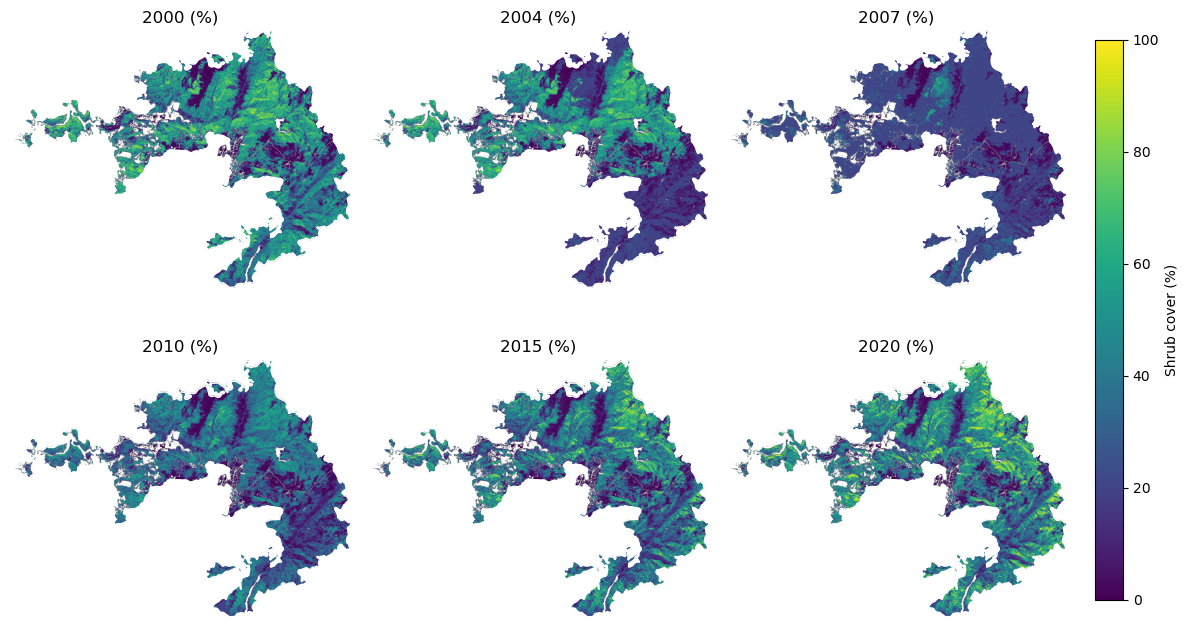

In [8]:
# ===========================================================
# Witch Fire shrub % maps (mirror of Cedar figure)
# ===========================================================

# Choose which years to show (adapt to your WITCH_YEARS definition)
witch_years_to_plot = [2000, 2004, 2007, 2010, 2015, 2020][:6]  # adjust as needed

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes_flat = axes.ravel()

for ax, year in zip(axes_flat, witch_years_to_plot):
    band, transform, meta = load_and_clip_rcmap_year(year, witch_3310)

    nrows_band, ncols_band = band.shape
    left = transform.c
    top = transform.f
    right = left + transform.a * ncols_band
    bottom = top + transform.e * nrows_band  # transform.e is negative

    im = ax.imshow(
        band,
        vmin=0,
        vmax=100,
        cmap="viridis",
        extent=(left, right, bottom, top),
        origin="upper",
    )

    witch_3310.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="white",
        linewidth=1,
    )

    ax.set_title(f"{year} (%)")
    ax.set_axis_off()

# Hide any unused axes (if fewer than 6 years)
for ax in axes_flat[len(witch_years_to_plot):]:
    ax.set_visible(False)

fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Shrub cover (%)")

plt.show()


### Step 4.1: Create a shrub cover difference timeseries
Here we are plotting the difference and histogram together so they will display at the same time.


=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 96.0

=== Loading RCMAP shrub for 2020 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_2011_2024\rcmap_shrub_2020.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 99.0
Witch mean change: 0.4074474
Witch min change: -73.0
Witch max change: 83.0


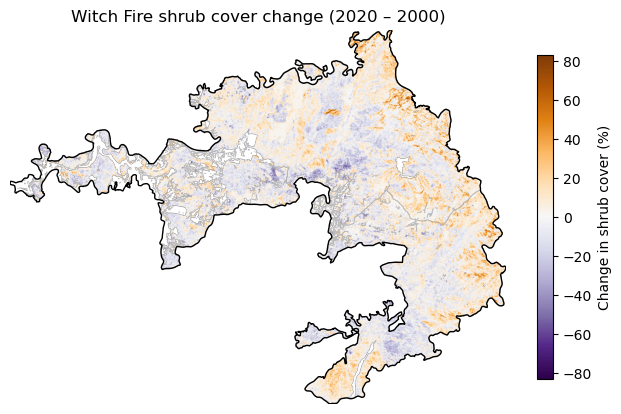

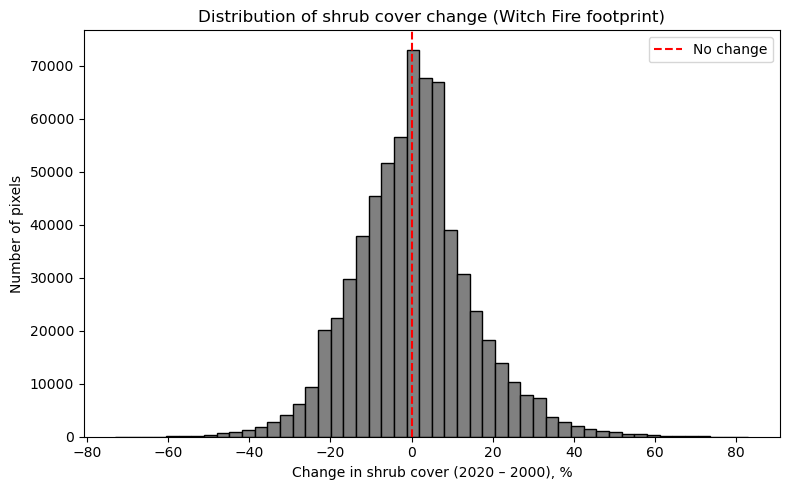

In [9]:
# ===========================================================
# Witch Fire shrub cover change (2020 - 2000)
# ===========================================================

witch_2000, witch_t2000, witch_meta_2000 = load_and_clip_rcmap_year(2000, witch_3310)
witch_2020, witch_t2020, witch_meta_2020 = load_and_clip_rcmap_year(2020, witch_3310)

valid_mask_witch = (~np.isnan(witch_2000)) & (~np.isnan(witch_2020))
witch_shrub_diff = np.where(valid_mask_witch, witch_2020 - witch_2000, np.nan)

print("Witch mean change:", np.nanmean(witch_shrub_diff))
print("Witch min change:", np.nanmin(witch_shrub_diff))
print("Witch max change:", np.nanmax(witch_shrub_diff))

# Map
fig, ax = plt.subplots(figsize=(8, 6))

nrows_diff, ncols_diff = witch_shrub_diff.shape
left = witch_t2000.c
top = witch_t2000.f
right = left + witch_t2000.a * ncols_diff
bottom = top + witch_t2000.e * nrows_diff

abs_max_w = np.nanmax(np.abs(witch_shrub_diff))

im = ax.imshow(
    witch_shrub_diff,
    cmap="PuOr_r",
    vmin=-abs_max_w,
    vmax=abs_max_w,
    extent=(left, right, bottom, top),
    origin="upper",
)

witch_3310.to_crs(witch_meta_2000["crs"]).boundary.plot(
    ax=ax,
    color="black",
    linewidth=1,
)

ax.set_title("Witch Fire shrub cover change (2020 – 2000)")
ax.set_axis_off()

cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Change in shrub cover (%)")

plt.show()

# Histogram
fig, ax = plt.subplots(figsize=(8, 5))

witch_valid_vals = witch_shrub_diff[~np.isnan(witch_shrub_diff)]

ax.hist(witch_valid_vals, bins=50, color="gray", edgecolor="black")
ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="No change")

ax.set_xlabel("Change in shrub cover (2020 – 2000), %")
ax.set_ylabel("Number of pixels")
ax.set_title("Distribution of shrub cover change (Witch Fire footprint)")
ax.legend()

plt.tight_layout()
plt.show()


### Step 4.2 Histogram masking for east-west and cohen's d

In [10]:
# ===========================================================
# Witch Fire: build east vs west masks from 2000 transform
# ===========================================================

nrows_w, ncols_w = witch_shrub_diff.shape

# X coordinates of column centers using the geotransform
x_coords_w = witch_t2000.c + np.arange(ncols_w) * witch_t2000.a

# Split at the midpoint
x_mid_w = np.median(x_coords_w)
print("Witch x-midpoint:", x_mid_w)

east_mask_cols_w = x_coords_w >= x_mid_w
west_mask_cols_w = x_coords_w < x_mid_w

# Expand to full raster shape
east_mask_w = np.tile(east_mask_cols_w, (nrows_w, 1))
west_mask_w = np.tile(west_mask_cols_w, (nrows_w, 1))

# Valid data mask
valid_mask_witch = ~np.isnan(witch_shrub_diff)


Witch x-midpoint: -1926721.1657657186


In [11]:
# ===========================================================
# Extract east vs west change values (Witch)
# ===========================================================

witch_east_values = witch_shrub_diff[east_mask_w & valid_mask_witch]
witch_west_values = witch_shrub_diff[west_mask_w & valid_mask_witch]

print("Witch east pixels:", witch_east_values.size)
print("Witch west pixels:", witch_west_values.size)

print("Witch east mean change:", np.nanmean(witch_east_values))
print("Witch west mean change:", np.nanmean(witch_west_values))
print("Witch east median change:", np.nanmedian(witch_east_values))
print("Witch west median change:", np.nanmedian(witch_west_values))


Witch east pixels: 524534
Witch west pixels: 139375
Witch east mean change: 1.1351314
Witch west mean change: -2.3311713
Witch east median change: 1.0
Witch west median change: -2.0


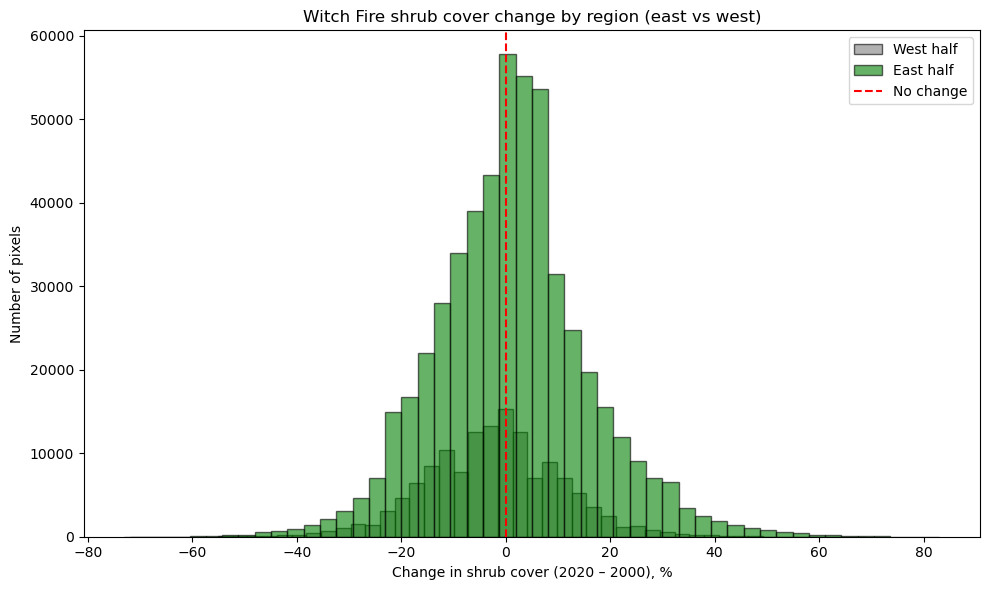

In [12]:
# ===========================================================
# Histogram of shrub-cover change (Witch east vs west)
# ===========================================================

fig, ax = plt.subplots(figsize=(10, 6))

bins = 50

ax.hist(
    witch_west_values,
    bins=bins,
    alpha=0.6,
    color="gray",
    edgecolor="black",
    label="West half",
)

ax.hist(
    witch_east_values,
    bins=bins,
    alpha=0.6,
    color="green",
    edgecolor="black",
    label="East half",
)

ax.axvline(0, color="red", linestyle="--", linewidth=1.5, label="No change")

ax.set_xlabel("Change in shrub cover (2020 – 2000), %")
ax.set_ylabel("Number of pixels")
ax.set_title("Witch Fire shrub cover change by region (east vs west)")
ax.legend()

plt.tight_layout()
plt.show()


### Step 4.3 Calculating cohen's d

In [13]:
# ===========================================================
# Cohen's d for Witch (east vs west shrub recovery)
# ===========================================================

sd_east_w = np.nanstd(witch_east_values, ddof=1)
sd_west_w = np.nanstd(witch_west_values, ddof=1)

n_east_w = len(witch_east_values)
n_west_w = len(witch_west_values)

pooled_sd_w = np.sqrt(
    (((n_east_w - 1) * sd_east_w**2) + ((n_west_w - 1) * sd_west_w**2)) / (n_east_w + n_west_w - 2)
)

cohens_d_witch = (np.nanmean(witch_east_values) - np.nanmean(witch_west_values)) / pooled_sd_w

cohens_d_witch


np.float32(0.24089809)

### How does Witch compare to Cedar in terms of shrub recovery distribution?

Although the east half of the Witch Fire perimeter contains a much larger number of pixels than the west—leading to taller histogram bars—the statistical distributions of shrub-cover change are remarkably similar between the two regions. Cohen’s d is only 0.24, indicating a small effect size and substantial overlap in recovery outcomes. In contrast to the Cedar Fire, which showed a strong east–west divergence in post-fire vegetation trajectories, the Witch Fire appears to have produced a more spatially uniform recovery across its footprint. This suggests that burn severity, species composition, and environmental gradients were less differentiated in the Witch Fire, resulting in more consistent shrub regeneration between the eastern and western portions of the perimeter.

### Step 5: Save plots and figures


=== Loading RCMAP shrub for 2000 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2000.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 96.0

=== Loading RCMAP shrub for 2004 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\raw\landcover\rcmap_shrub\Shrub_1998_2010\rcmap_shrub_2004.tif
RCMAP CRS: EPSG:5070
RCMAP bounds: BoundingBox(left=-2875426.1657657186, bottom=309855.9458113904, right=592483.8342342814, top=3290175.9458113904)
RCMAP nodata: 101.0
Clipped array shape (rows, cols): (1280, 1696)
Min shrub %: 0.0
Max shrub %: 92.0

=== Loading RCMAP shrub for 2007 ===
Using file: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-r

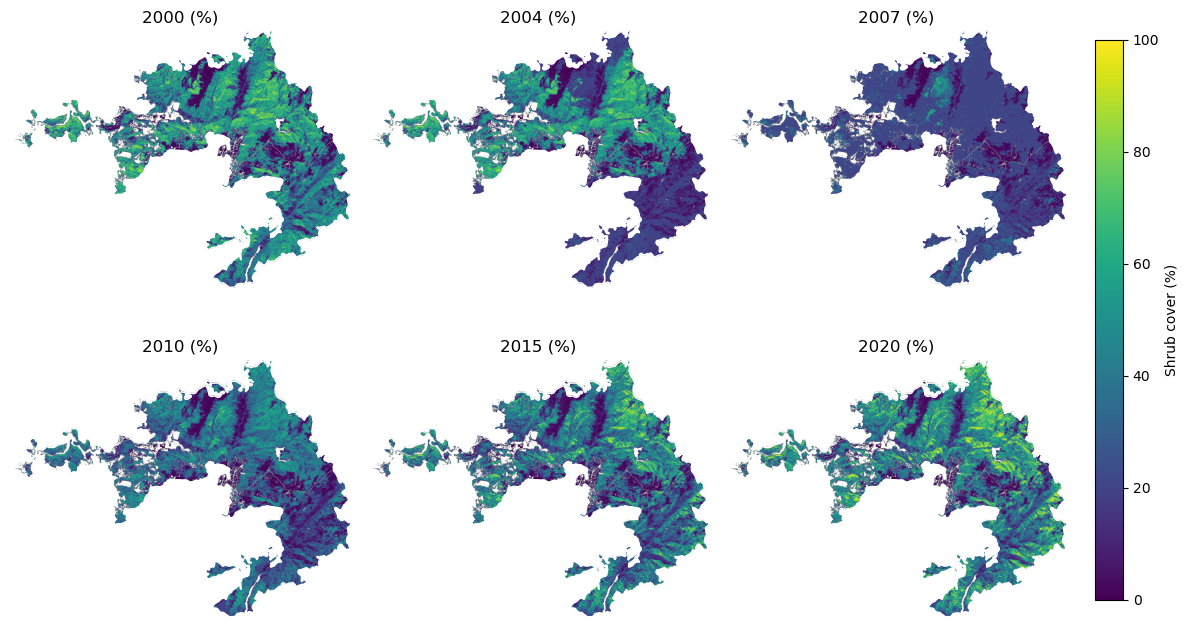

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover/witch_shrub_cover_maps.png')

In [14]:
# ===========================================================
# Export: Witch Fire 2×3 shrub % maps
# ===========================================================
# Use the existing FIG_DIR and just add a subfolder for landcover
LANDCOVER_FIG_DIR = FIG_DIR / "landcover"
LANDCOVER_FIG_DIR.mkdir(parents=True, exist_ok=True)

LANDCOVER_FIG_DIR


witch_years_to_plot = [2000, 2004, 2007, 2010, 2015, 2020][:6]  # adjust as needed

nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 8))
axes_flat = axes.ravel()

for ax, year in zip(axes_flat, witch_years_to_plot):
    band, transform, meta = load_and_clip_rcmap_year(year, witch_3310)

    nrows_band, ncols_band = band.shape
    left = transform.c
    top = transform.f
    right = left + transform.a * ncols_band
    bottom = top + transform.e * nrows_band  # transform.e is negative

    im = ax.imshow(
        band,
        vmin=0,
        vmax=100,
        cmap="viridis",
        extent=(left, right, bottom, top),
        origin="upper",
    )

    witch_3310.to_crs(meta["crs"]).boundary.plot(
        ax=ax,
        color="white",
        linewidth=1,
    )

    ax.set_title(f"{year} (%)")
    ax.set_axis_off()

# Hide any unused axes (if fewer than 6 years)
for ax in axes_flat[len(witch_years_to_plot):]:
    ax.set_visible(False)

fig.subplots_adjust(right=0.88, wspace=0.05, hspace=0.15)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Shrub cover (%)")

witch_maps_path = LANDCOVER_FIG_DIR / "witch_shrub_cover_maps.png"
fig.savefig(witch_maps_path, dpi=300)
plt.show()

witch_maps_path


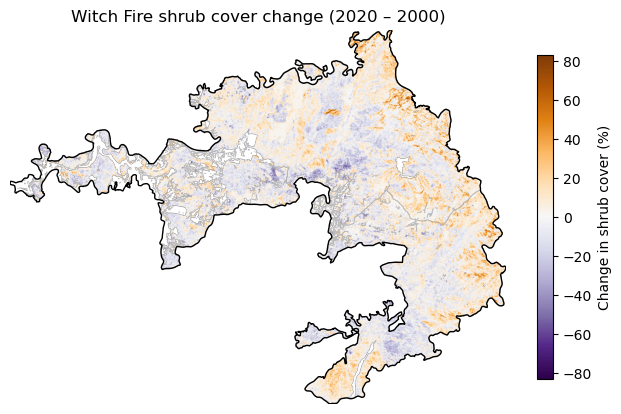

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover/witch_shrub_change_2020_minus_2000.png')

In [15]:
# ===========================================================
# Export: Witch Fire shrub change map
# ===========================================================

fig, ax = plt.subplots(figsize=(8, 6))

nrows_diff, ncols_diff = witch_shrub_diff.shape
left = witch_t2000.c
top = witch_t2000.f
right = left + witch_t2000.a * ncols_diff
bottom = top + witch_t2000.e * nrows_diff

abs_max_w = np.nanmax(np.abs(witch_shrub_diff))

im = ax.imshow(
    witch_shrub_diff,
    cmap="PuOr_r",
    vmin=-abs_max_w,
    vmax=abs_max_w,
    extent=(left, right, bottom, top),
    origin="upper",
)

witch_3310.to_crs(witch_meta_2000["crs"]).boundary.plot(
    ax=ax,
    color="black",
    linewidth=1,
)

ax.set_title("Witch Fire shrub cover change (2020 – 2000)")
ax.set_axis_off()

cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Change in shrub cover (%)")

witch_change_path = LANDCOVER_FIG_DIR / "witch_shrub_change_2020_minus_2000.png"
fig.savefig(witch_change_path, dpi=300, bbox_inches="tight")
plt.show()

witch_change_path


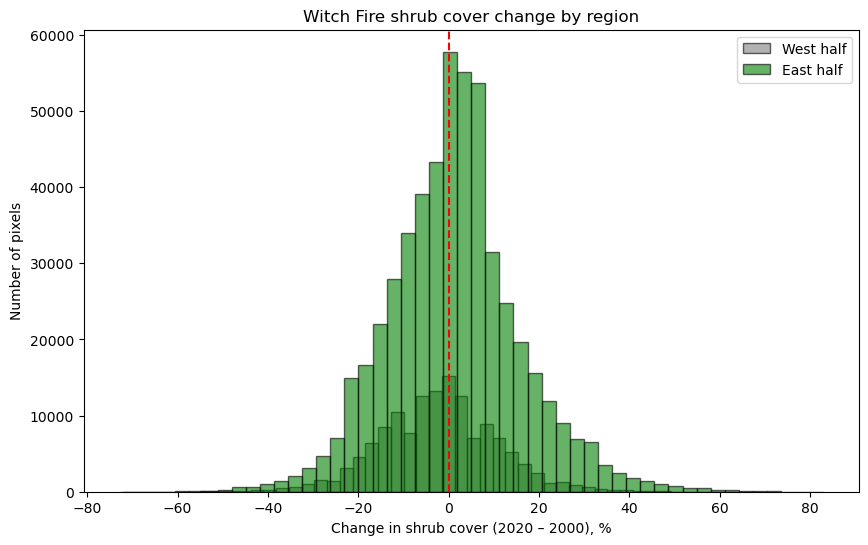

WindowsPath('C:/Users/kayle/Desktop/earth-analytics/Final project/ramona-fire-recovery/figures/landcover/witch_shrub_change_hist_east_vs_west.png')

In [16]:
# ===========================================================
# Export: East vs West histogram (Witch)
# ===========================================================

fig, ax = plt.subplots(figsize=(10, 6))
bins = 50

ax.hist(
    witch_west_values,
    bins=bins, alpha=0.6,
    color="gray", edgecolor="black",
    label="West half"
)

ax.hist(
    witch_east_values,
    bins=bins, alpha=0.6,
    color="green", edgecolor="black",
    label="East half"
)

ax.axvline(0, color="red", linestyle="--", linewidth=1.5)

ax.set_xlabel("Change in shrub cover (2020 – 2000), %")
ax.set_ylabel("Number of pixels")
ax.set_title("Witch Fire shrub cover change by region")
ax.legend()

witch_hist_path = LANDCOVER_FIG_DIR / "witch_shrub_change_hist_east_vs_west.png"
fig.savefig(witch_hist_path, dpi=300, bbox_inches="tight")
plt.show()

witch_hist_path


In [17]:
# ===========================================================
# Save Witch Fire variables and statistics
# ===========================================================

processed_dir = DATA_DIR / "processed" / "landcover"
processed_dir.mkdir(parents=True, exist_ok=True)

# Time series CSV
witch_time_csv = processed_dir / "witch_shrub_cover_time.csv"
witch_shrub_df.to_csv(witch_time_csv, index=True)

# East–west summary CSV
witch_summary_csv = processed_dir / "witch_shrub_change_east_west_summary.csv"

summary_records_w = [
    {
        "region": "east",
        "n_pixels": len(witch_east_values),
        "mean_change": float(np.nanmean(witch_east_values)),
        "median_change": float(np.nanmedian(witch_east_values)),
        "std_change": float(np.nanstd(witch_east_values, ddof=1)),
    },
    {
        "region": "west",
        "n_pixels": len(witch_west_values),
        "mean_change": float(np.nanmean(witch_west_values)),
        "median_change": float(np.nanmedian(witch_west_values)),
        "std_change": float(np.nanstd(witch_west_values, ddof=1)),
    },
]

witch_summary_df = pd.DataFrame(summary_records_w)
witch_summary_df["cohens_d_east_minus_west"] = float(cohens_d_witch)
witch_summary_df.to_csv(witch_summary_csv, index=False)

# NPZ file for easy loading later
witch_npz_path = processed_dir / "witch_core_arrays.npz"

np.savez(
    witch_npz_path,
    shrub_diff=witch_shrub_diff,
    east_values=witch_east_values,
    west_values=witch_west_values,
    east_mask=east_mask_w,
    west_mask=west_mask_w,
    transform_2000=np.array(witch_t2000),
    transform_2020=np.array(witch_t2020),
    witch_bounds=np.array(witch_3310.total_bounds),
    cohens_d=float(cohens_d_witch)
)

print("Stored Witch variables:")
print(f"- Time series CSV: {witch_time_csv}")
print(f"- Summary CSV:     {witch_summary_csv}")
print(f"- Core NPZ:        {witch_npz_path}")


Stored Witch variables:
- Time series CSV: C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\processed\landcover\witch_shrub_cover_time.csv
- Summary CSV:     C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\processed\landcover\witch_shrub_change_east_west_summary.csv
- Core NPZ:        C:\Users\kayle\Desktop\earth-analytics\Final project\ramona-fire-recovery\data\processed\landcover\witch_core_arrays.npz


### Step 6: Store variables

In [19]:
%store witch_shrub_df RCMAP_YEAR_FILES

Stored 'witch_shrub_df' (DataFrame)
Stored 'RCMAP_YEAR_FILES' (dict)
